In [74]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.pylab as pylab
plt.style.use('bmh')
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (20, 10),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
from IPython.core.display import display, HTML
pylab.rcParams.update(params)
display(HTML("<style>.container { width:80% !important; }</style>"))
pd.set_option('display.max_columns', None)
from sklearn.preprocessing import StandardScaler

In [75]:
df = pd.read_csv("y_hat_final.csv")
df['Date'] =  pd.to_datetime(df['Date'])
df.set_index("Date",inplace=True)
df.shape
df.rename(columns={"y":"Close"},inplace=True)

In [76]:
signals = pd.DataFrame(index=df.index)
signals['signal'] = 0.0

In [77]:
signals["Close"] = df.Close.copy()

In [78]:
signals.signal.iloc[0]=1
signals.signal.iloc[1]=1
signals.signal.iloc[2]=1
signals.signal.iloc[3]=1
signals.signal.iloc[4]=1
signals.signal.iloc[5]=1
signals.signal.iloc[6]=1
signals.signal.iloc[7]=1
signals.signal.iloc[8]=1
signals.signal.iloc[9]=1
signals.signal.iloc[10]=1

signals.signal.iloc[-1]=-1
signals.signal.iloc[-2]=-1
signals.signal.iloc[-3]=-1
signals.signal.iloc[-4]=-1
signals.signal.iloc[-5]=-1
signals.signal.iloc[-6]=-1
signals.signal.iloc[-7]=-1
signals.signal.iloc[-8]=-1
signals.signal.iloc[-9]=-1
signals.signal.iloc[-10]=-1
# signals.signal.iloc[-1]=-1

In [79]:
def buy_stock(
    real_movement,
    signal,
    initial_money = 10000,
    max_buy = 10000,
    max_sell = 10000
):
    """
    real_movement = actual movement in the real world
    delay = how much interval you want to delay to change our decision from buy to sell, vice versa
    initial_state = 1 is buy, 0 is sell
    initial_money = 1000, ignore what kind of currency
    max_buy = max quantity for share to buy
    max_sell = max quantity for share to sell
    """
    starting_money = initial_money
    states_sell = []
    states_buy = []
    current_inventory = 0
    
    total = list()
    
    def buy(i, initial_money, current_inventory):
        shares = initial_money // real_movement[i]
        if shares < 1:
            print(
                'day %d: total balances %f, not enough money to buy a unit price %f'
                % (i, initial_money, real_movement[i])
            )
        else:
            if shares > max_buy:
                buy_units = max_buy
            else:
                buy_units = shares
            initial_money -= buy_units * real_movement[i]
            current_inventory += buy_units
            print(
                'day %d: buy %d units at price %f, total balance %f'
                % (i, buy_units, buy_units * real_movement[i], initial_money)
            )
            states_buy.append(0)
        return initial_money, current_inventory

    for i in range(real_movement.shape[0]):
        state = signal[i]
        if state == 1:
            initial_money, current_inventory = buy(
                i, initial_money, current_inventory
            )
            states_buy.append(i)
        elif state == -1:
            if current_inventory == 0:
                    print('day %d: cannot sell anything, inventory 0' % (i))
            else:
                if current_inventory > max_sell:
                    sell_units = max_sell
                else:
                    sell_units = current_inventory
                current_inventory -= sell_units
                total_sell = sell_units * real_movement[i]
                initial_money += total_sell
                try:
                    invest = (
                        (real_movement[i] - real_movement[states_buy[-1]])
                        / real_movement[states_buy[-1]]
                    ) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell %d units at price %f, investment %f %%, total balance %f,'
                    % (i, sell_units, total_sell, invest, initial_money)
                )
            states_sell.append(i)
        total.append(current_inventory*real_movement[i]+initial_money)
    print(current_inventory)
    try:
        adj = (current_inventory*real_movement[-1])
    except:
        adj = 0
            
    invest = ((initial_money + adj - starting_money) / starting_money) * 100
    total_gains = initial_money + adj - starting_money
    return states_buy, states_sell, total_gains, invest,total

In [80]:
states_buy, states_sell, total_gains, invest,total = buy_stock(df.Close, signals['signal'])

day 0: buy 7156 units at price 9999.078800, total balance 0.921200
day 1: total balances 0.921200, not enough money to buy a unit price 1.431500
day 2: total balances 0.921200, not enough money to buy a unit price 1.442300
day 3: total balances 0.921200, not enough money to buy a unit price 1.448600
day 4: total balances 0.921200, not enough money to buy a unit price 1.437600
day 5: total balances 0.921200, not enough money to buy a unit price 1.488600
day 6: total balances 0.921200, not enough money to buy a unit price 1.420500
day 7: total balances 0.921200, not enough money to buy a unit price 1.439900
day 8: total balances 0.921200, not enough money to buy a unit price 1.417400
day 9: total balances 0.921200, not enough money to buy a unit price 1.479400
day 10: total balances 0.921200, not enough money to buy a unit price 1.437300
day 242, sell 7156 units at price 11690.757200, investment 13.664510 %, total balance 11691.678400,
day 243: cannot sell anything, inventory 0
day 244: 

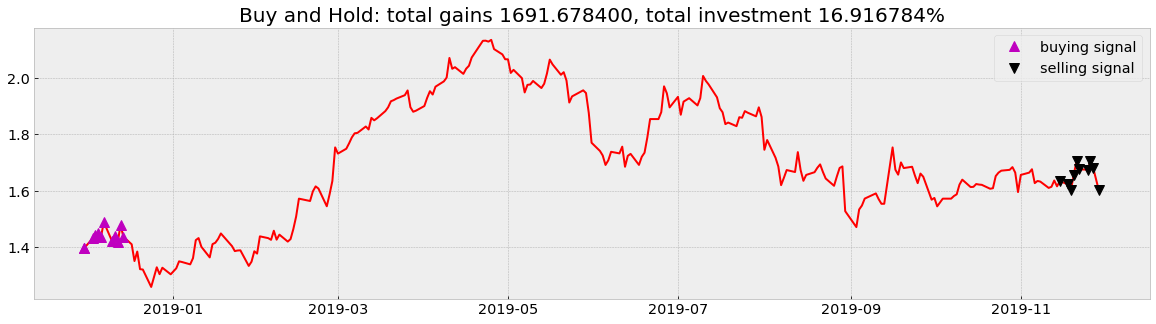

In [94]:
close = df['Close']
fig = plt.figure(figsize = (20,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('Buy and Hold: total gains %f, total investment %f%%'%(total_gains, invest),fontsize=20)
plt.legend()
plt.savefig("fig11.png")
plt.show()

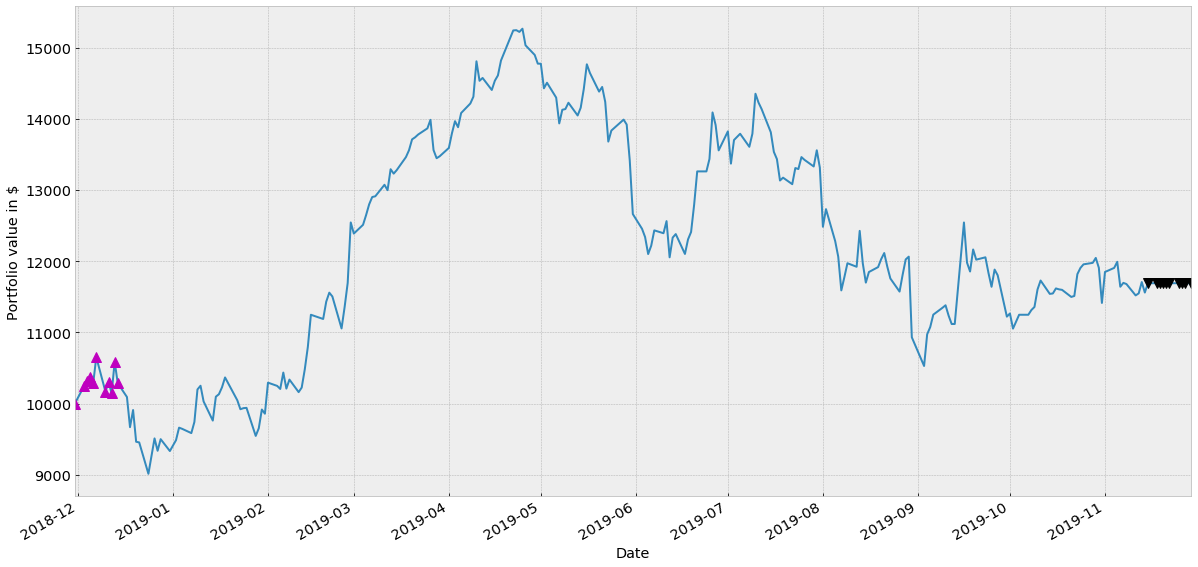

In [86]:
totals = pd.DataFrame(index=df.index)
totals["total"] = total
totals['signals'] = signals['signal']
totals["returns"] = totals['total'].pct_change()
# Import the `pyplot` module as `plt`
import matplotlib.pyplot as plt

# Create a figure
fig = plt.figure()

ax1 = fig.add_subplot(111, ylabel='Portfolio value in $')

# Plot the equity curve in dollars
totals['total'].plot(ax=ax1, lw=2.)

ax1.plot(totals.loc[totals['signals']== 1.0].index, 
         totals.total[totals['signals'] == 1.0],
         '^', markersize=10, color='m')
ax1.plot(totals.loc[totals['signals'] == -1.0].index, 
         totals.total[totals['signals'] == -1.0],
         'v', markersize=10, color='k')

# Show the plot
plt.show()

In [89]:
totals.returns.describe()

count    251.000000
mean       0.000887
std        0.023058
min       -0.093949
25%       -0.012478
50%        0.002485
75%        0.012685
max        0.128264
Name: returns, dtype: float64

Start date,2018-11-30
End date,2019-11-29
Total months,12
,Backtest
Annual return,16.9%
Cumulative returns,16.9%
Annual volatility,36.6%
Sharpe ratio,0.61
Calmar ratio,0.54
Stability,0.06
Max drawdown,-31.0%


C:\Users\wozni\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return getattr(obj, method)(*args, **kwds)


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,31.04,2019-04-25,2019-09-03,NaT,NaN
1,15.39,2018-12-07,2018-12-24,2019-02-14,50
2,4.35,2019-02-21,2019-02-25,2019-02-27,5
3,3.86,2019-03-26,2019-03-28,2019-04-05,9
4,2.72,2019-04-10,2019-04-15,2019-04-18,7


C:\Users\wozni\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return getattr(obj, method)(*args, **kwds)


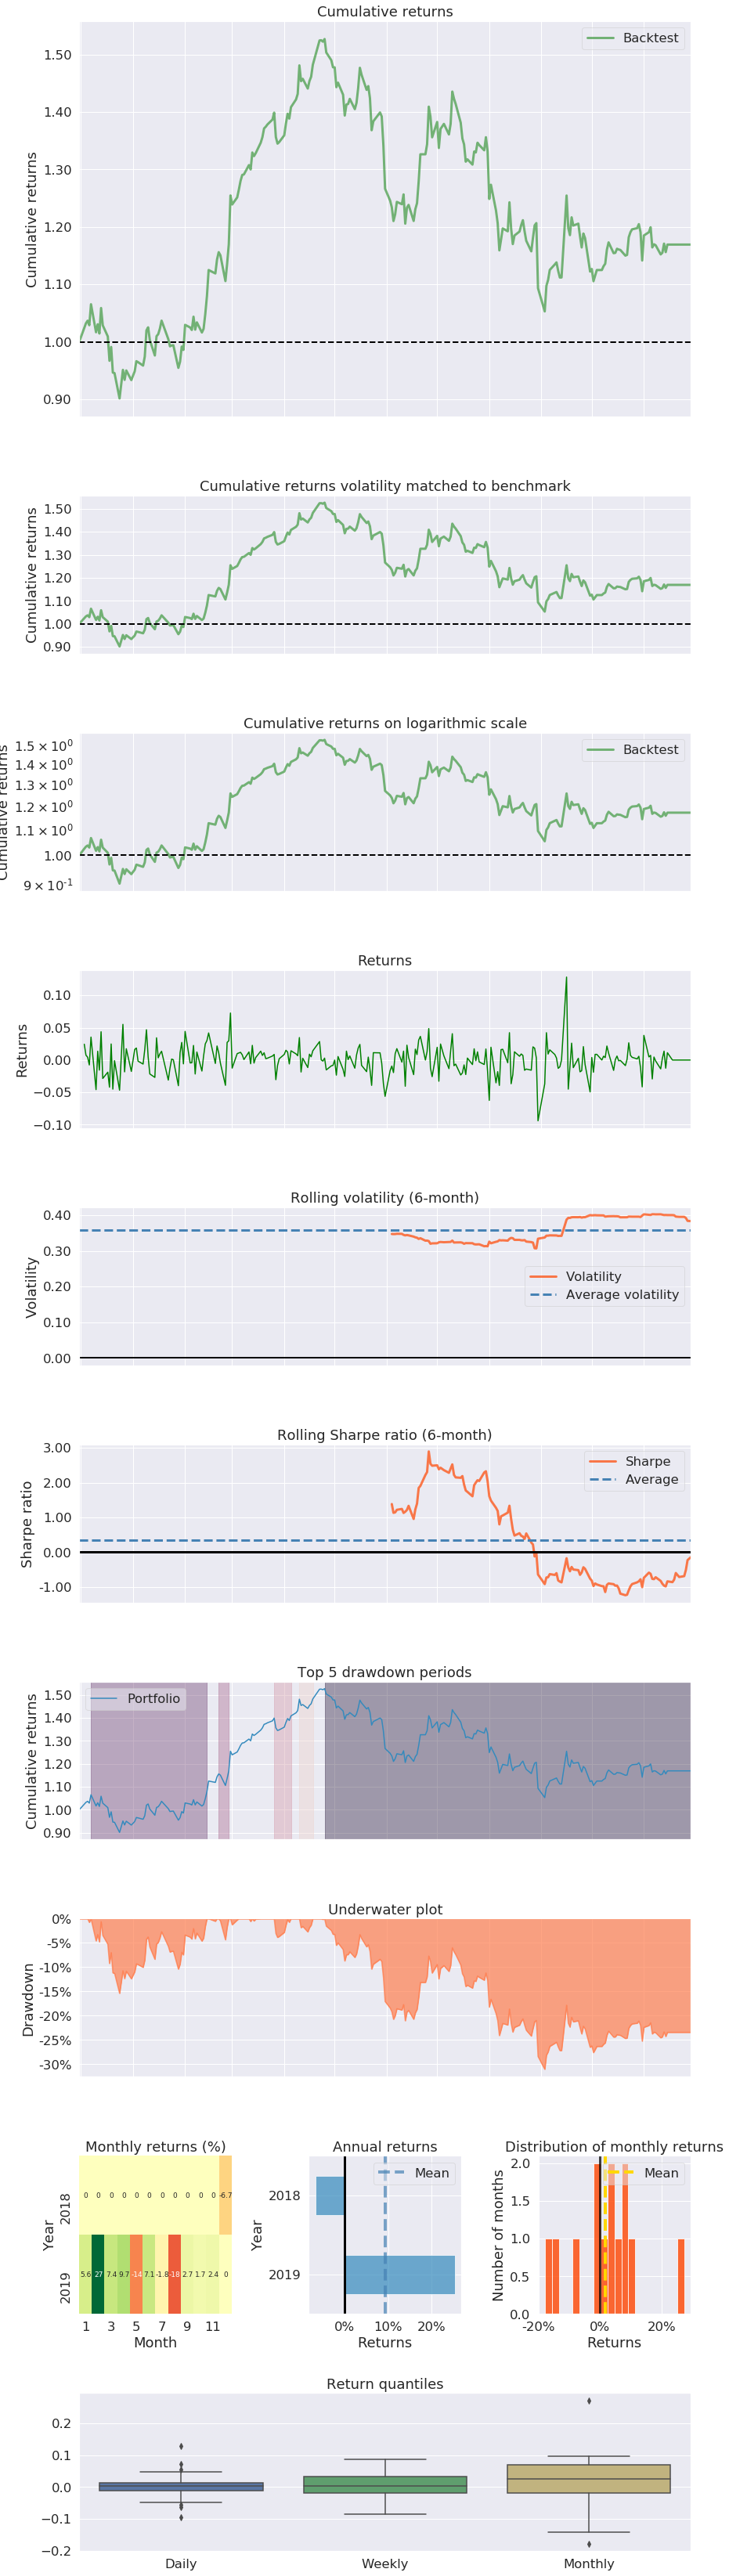

In [85]:
import pyfolio as pf
tmp = pf.create_returns_tear_sheet(totals.returns)